# Graph Classification

In this notebook we use node embedding generation techniques and manifold learning to create features from graph in order to classify nodes

- [Import Libraries](#libs)

- [Load Data](#load-data)

- [Helpers](#helpers)
 - Composed ego graphs for nodes of interest
 - Composed ego graphs for graph reduction
- [Node/Graph embeddings](#embeds)
 - DeepWalk
 - Node2Vec
 - LINE
 - Struct2Vec
 
- [Models](#models)

### Import Libs <a id='libs'></a>

In [31]:
import csv
import networkx as nx
import numpy as np
import pickle
from random import randint
from gensim.models import Word2Vec
import tqdm
sys.path.insert(0,'C:/Users/User/Desktop/DS_challenge/')

import numpy as np
from GraphEmbedding.ge import DeepWalk, Struc2Vec
from GraphEmbedding.ge.classify import read_node_label, Classifier
from GraphEmbedding.ge import DeepWalk
from GraphEmbedding.ge import models

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.manifold import TSNE

from statistics import mean 
import random
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import networkx as nx

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Data<a id='load-data'></a>

In [28]:
dir_path = r'C:\Users\User\Desktop\DS_challenge\data\\'
TRAIN_FILE = dir_path + "train.csv"
TEST_FILE = dir_path + "test.csv"
GRAPH_FILE = dir_path + "edgelist.txt"
domains_path = 'C:/Users/User/Desktop/DS_challenge/data/data_science_challenge_2019/domains/'

In [53]:
# Read training data

class_labels = {'athlitismos':0, 'diaskedasi-psyxagogia':1, 'eidiseis-mme':2, 'katastimata-agores':3, 'pliroforiki-diadiktyo':4}

train_hosts = list()
train_labels = list()
with open(TRAIN_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        train_hosts.append(l[0])
        train_labels.append(l[1][:-1])

y_train_class = []
y_train_dum = np.zeros((len(train_hosts), len(class_labels)))
for i, train_label in enumerate(train_labels):
    y_train_dum[i,class_labels[train_label]] = 1
    y_train_class.append(class_labels[train_label])
        

# Read test data
test_hosts = list()
with open(TEST_FILE, 'r') as f:
    for line in f:
        l = line.split(',')
        test_hosts.append(l[0])

# Create a directed graph
G = nx.read_edgelist(GRAPH_FILE, delimiter=' ', create_using=nx.DiGraph())

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 65208
Number of edges: 1642073


## Helpers <a id='helpers'></a>

Some of the Graph/Node embedding models(SDNE-Struc2Vec etc) are too heavy for our hardware. So, we create a smaller graph for the nodes that we'll use. However, for computational reasons we can only create a sugraph with radius 1 from our nodes. As a result, we wont get any good results. It has academic purpose.

In [18]:
c = 0
G_trunc=nx.Graph()
for doc_label in tqdm(train_hosts):
    sub_graph = nx.ego_graph(G, str(doc_label), radius=1)
    G_trunc = nx.compose(G_trunc, sub_graph)
    c+=1
nx.write_gpickle(G_trunc,"graph_trunc.gpickle")

TypeError: 'module' object is not callable

**Visualization with TNSE helper function**

In [20]:
def plot_embeddings(embeddings,X, Y):
    emb_list = []
    for k, host in enumerate(X):
        emb_list.append(embeddings[host])
    emb_list = np.array(emb_list)

    model = TSNE(n_components=2)
    node_pos = model.fit_transform(emb_list)

    color_idx = {}
    for i in range(len(X)):
        color_idx.setdefault(Y[i], [])
        color_idx[Y[i]].append(i)

    for c, idx in color_idx.items():
        plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
    plt.legend()
    plt.show()

## Node/Graph Embeddings <a id='embeds'></a>

### Train Random Walk Embeddings

In [6]:
walk_len = 60
num_walks = 200
ws = 6
embed_size = 100

In [7]:
model = DeepWalk(G,walk_length=walk_len,num_walks=num_walks,workers=1)#init model
model.train(embed_size = embed_size, window_size=ws, iter=3)# train model
embeddings_rw = model.get_embeddings()# get embedding vectors

# Save to pickle
save_dir = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/'
filename = 'random_walk_{}_{}_lib'.format(walk_len, num_walks)
pickle_out = open(save_dir + filename,"wb")
pickle.dump(model, pickle_out)
pickle_out.close()

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 out of   8 | elapsed:  3.2min remaining:  3.2min
[Parallel(n_jobs=7)]: Done   8 out of   8 | elapsed:  6.2min finished


Learning embedding vectors...


C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


KeyboardInterrupt: 

After trial and error the embeddings for the RW algorithm were calculated with:
* walk length = 250
* num walks = 100
* window = 7
* embedding size = 100

In [225]:
# Load Trained Embeddings
filename = 'random_walk_{}_{}_lib'.format(walk_len, num_walks)
serialized_w2v_250_path = save_path + filename
with open(serialized_w2v_250_path, 'rb') as file:
        model_rw = pickle.load(file)  

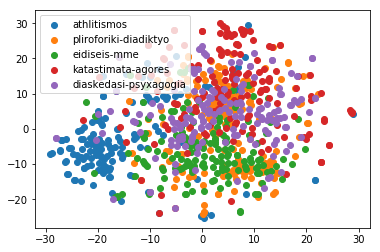

In [211]:
plot_embeddings(embeddings_rw, train_hosts, y_train)

Below we can get embeddings with more number of walks than walk lenght. We can see that the two graphs similar, like the above has been rotated by an angle

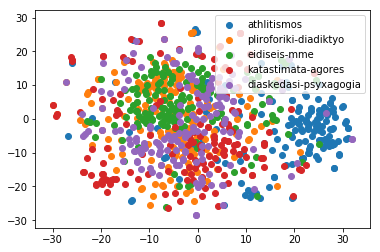

In [215]:
plot_embeddings(embeddings_rw, train_hosts, y_train)

## Train Struc2Vec Embeddings

Note: Due to lack of the resources required to train the struc2vec on the entire graph we took subgtaphs for train and test and we trained our s2v embeddings there.

In [22]:
#Model Params
walk_length = 100
num_walks = 80
embed_size = 100

### Train

In [65]:
# k = G.subgraph(train_hosts)
# print(len(k.edges))
# print(len(k.nodes))

s2v = Struc2Vec(G_trunc, walk_length=10, num_walks=20, workers=4, verbose=40, ) #init model
s2v.train(embed_size = embed_size, window_size = 1, iter = 2)# train model
s2v_embeddings = s2v.get_embeddings()# get embedding vectors

KeyboardInterrupt: 

In [ ]:
filename = 's2v_train_{}_{}_lib'.format(walk_len, num_walks)
pickle_out = open(save_path+filename,"wb")
pickle.dump(s2v, pickle_out)
pickle_out.close()

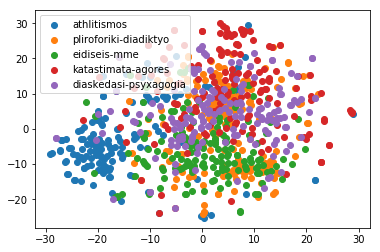

In [211]:
plot_embeddings(s2v_embeddings, train_hosts, y_train)

### Test

In [ ]:
k = G.subgraph(test_hosts)
print(len(k.edges))
print(len(k.nodes))

s2v_test = models.Struc2Vec(k, walk_length=20, num_walks=10, workers=4, verbose=40, ) #init model
s2v_test.train(window_size = 5, iter = 3)# train model
s2v_embeddings_test = s2v_test.get_embeddings()# get embedding vectors

In [ ]:
filename = 's2v_test_{}_{}_lib'.format(walk_len, num_walks)
pickle_out = open(save_path+filename,"wb")
pickle.dump(s2v_test, pickle_out)
pickle_out.close()

## Train Node2Vec Embeddings

In [ ]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G, dimensions=100, walk_length=20, num_walks=10)

# Learn embeddings 
model_n2v = node2vec.fit(window=5, min_count=1)

# save the model to disk
filename = 'node2vec_graph_100.sav.sav'
pickle.dump(model_n2v, open(filename, 'wb'))

In [219]:
filename = 'node2vec_graph_100.sav'
with open(save_path+filename, 'rb') as file:
        model_n2v = pickle.load(file)  

/Users/georgiasarri/Workspace/Environments/python37/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


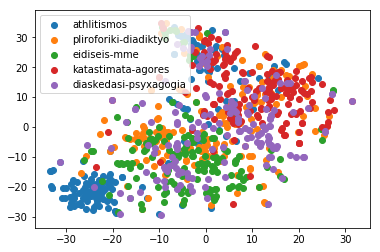

In [223]:
plot_embeddings(model_n2v, train_hosts, y_train)

## Train LINE Embeddings

In [57]:
from GraphEmbedding.ge import models

line = models.LINE(G, embedding_size=100, order='second')
line.train(batch_size=1024, epochs=3, verbose=1)
embeddings_line = line.get_embeddings()

{}
{}
{}
{}
Instructions for updating:
keep_dims is deprecated, use keepdims instead
{}
{}


C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/3


 598/9622 [>.............................] - ETA: 17:36:16 - loss: 0.693 - ETA: 5:55:35 - loss: 0.693 - ETA: 3:35:34 - loss: 0.69 - ETA: 2:35:24 - loss: 0.69 - ETA: 2:02:02 - loss: 0.69 - ETA: 1:40:50 - loss: 0.69 - ETA: 1:26:14 - loss: 0.69 - ETA: 1:20:41 - loss: 0.69 - ETA: 1:15:52 - loss: 0.69 - ETA: 1:11:39 - loss: 0.69 - ETA: 1:08:05 - loss: 0.69 - ETA: 1:05:16 - loss: 0.69 - ETA: 1:02:37 - loss: 0.69 - ETA: 1:00:10 - loss: 0.69 - ETA: 58:01 - loss: 0.6932 - ETA: 55:44 - loss: 0.69 - ETA: 53:42 - loss: 0.69 - ETA: 49:55 - loss: 0.69 - ETA: 46:42 - loss: 0.69 - ETA: 43:55 - loss: 0.69 - ETA: 41:30 - loss: 0.69 - ETA: 39:20 - loss: 0.69 - ETA: 37:26 - loss: 0.69 - ETA: 35:44 - loss: 0.69 - ETA: 35:00 - loss: 0.69 - ETA: 33:33 - loss: 0.69 - ETA: 32:55 - loss: 0.69 - ETA: 31:41 - loss: 0.69 - ETA: 30:31 - loss: 0.69 - ETA: 29:30 - loss: 0.69 - ETA: 28:33 - loss: 0.69 - ETA: 27:41 - loss: 0.69 - ETA: 26:53 - loss: 0.69 - ETA: 26:07 - loss: 0.69 - ETA: 25:25 - loss: 0.69 - ETA: 24:46 -

4337/9622 [============>.................] - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:51 - loss: 0.405 - ETA: 3:50 - loss: 0.405 - ETA: 3:50 - loss: 0.405 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:50 - loss: 0.404 - ETA: 3:49 - loss: 0.404 - ETA: 3:49 - loss: 0.404 - ETA: 3:49 - loss: 0.404 - ETA: 3:49 - loss: 0.404 - ETA: 3:49 - loss: 0.404 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:49 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0.403 - ETA: 3:48 - loss: 0

4963/9622 [==============>...............] - ETA: 3:25 - loss: 0.386 - ETA: 3:25 - loss: 0.386 - ETA: 3:25 - loss: 0.386 - ETA: 3:25 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.386 - ETA: 3:24 - loss: 0.385 - ETA: 3:24 - loss: 0.386 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:23 - loss: 0.385 - ETA: 3:22 - loss: 0.385 - ETA: 3:22 - loss: 0.385 - ETA: 3:22 - loss: 0.385 - ETA: 3:22 - loss: 0.385 - ETA: 3:22 - loss: 0.384 - ETA: 3:22 - loss: 0.385 - ETA: 3:22 - loss: 0.384 - ETA: 3:22 - loss: 0.384 - ETA: 3:22 - loss: 0

5291/9622 [===============>..............] - ETA: 2:59 - loss: 0.372 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.372 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:59 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0.371 - ETA: 2:58 - loss: 0

5605/9622 [================>.............] - ETA: 2:58 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.364 - ETA: 2:59 - loss: 0.364 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.365 - ETA: 2:59 - loss: 0.364 - ETA: 2:59 - loss: 0.364 - ETA: 2:59 - loss: 0.364 - ETA: 2:59 - loss: 0

5919/9622 [=================>............] - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0.359 - ETA: 2:55 - loss: 0

6233/9622 [==================>...........] - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:47 - loss: 0.354 - ETA: 2:46 - loss: 0.354 - ETA: 2:46 - loss: 0

6547/9622 [===================>..........] - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.350 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:39 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0.349 - ETA: 2:38 - loss: 0

6861/9622 [====================>.........] - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:29 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0.345 - ETA: 2:28 - loss: 0

7175/9622 [=====================>........] - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:17 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0.341 - ETA: 2:16 - loss: 0

7489/9622 [======================>.......] - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:04 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0.337 - ETA: 2:03 - loss: 0

7803/9622 [=======================>......] - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:50 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.334 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:49 - loss: 0.333 - ETA: 1:48 - loss: 0

8117/9622 [========================>.....] - ETA: 1:36 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:35 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0.330 - ETA: 1:34 - loss: 0

8431/9622 [=========================>....] - ETA: 1:21 - loss: 0.327 - ETA: 1:21 - loss: 0.327 - ETA: 1:21 - loss: 0.327 - ETA: 1:21 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:20 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0.327 - ETA: 1:19 - loss: 0

8762/9622 [==========================>...] - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:05 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:04 - loss: 0.324 - ETA: 1:03 - loss: 0.324 - ETA: 1:03 - loss: 0.324 - ETA: 1:03 - loss: 0.324 - ETA: 1:03 - loss: 0.324 - ETA: 1:03 - loss: 0.324 - ETA: 1:03 - loss: 0

9102/9622 [===========================>..] - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 47s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 46s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.32 - ETA: 45s - loss: 0.

9442/9622 [============================>.] - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 29s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 28s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.31 - ETA: 27s - loss: 0.

9622/9622 [==============================] - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 10s - loss: 0.31 - ETA: 9s - loss: 0.3161 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.316 - ETA: 9s - loss: 0.315 - ETA: 9s - loss: 0.315 - ETA: 8s - loss: 0.316 - ETA: 8s - loss: 0.316 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.315 - ETA: 8s - loss: 0.

 314/9622 [..............................] - ETA: 8:57 - loss: 0.113 - ETA: 11:45 - loss: 0.10 - ETA: 13:12 - loss: 0.35 - ETA: 13:32 - loss: 0.29 - ETA: 14:15 - loss: 0.25 - ETA: 13:47 - loss: 0.23 - ETA: 14:28 - loss: 0.21 - ETA: 14:34 - loss: 0.19 - ETA: 14:34 - loss: 0.27 - ETA: 14:19 - loss: 0.25 - ETA: 14:13 - loss: 0.24 - ETA: 14:27 - loss: 0.23 - ETA: 14:23 - loss: 0.22 - ETA: 14:18 - loss: 0.21 - ETA: 14:21 - loss: 0.25 - ETA: 14:55 - loss: 0.24 - ETA: 14:54 - loss: 0.23 - ETA: 15:03 - loss: 0.23 - ETA: 15:07 - loss: 0.22 - ETA: 15:04 - loss: 0.21 - ETA: 14:58 - loss: 0.25 - ETA: 14:55 - loss: 0.24 - ETA: 14:54 - loss: 0.23 - ETA: 14:44 - loss: 0.23 - ETA: 14:40 - loss: 0.22 - ETA: 14:43 - loss: 0.22 - ETA: 14:45 - loss: 0.24 - ETA: 14:37 - loss: 0.24 - ETA: 14:40 - loss: 0.23 - ETA: 14:33 - loss: 0.23 - ETA: 14:33 - loss: 0.22 - ETA: 14:31 - loss: 0.22 - ETA: 14:34 - loss: 0.24 - ETA: 14:32 - loss: 0.24 - ETA: 14:33 - loss: 0.23 - ETA: 14:33 - loss: 0.23 - ETA: 14:34 - loss: 

2198/9622 [=====>........................] - ETA: 9:13 - loss: 0.229 - ETA: 9:13 - loss: 0.229 - ETA: 9:13 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:12 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:11 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:10 - loss: 0.229 - ETA: 9:09 - loss: 0.229 - ETA: 9:09 - loss: 0.229 - ETA: 9:09 - loss: 0.229 - ETA: 9:09 - loss: 0.229 - ETA: 9:09 - loss: 0

2512/9622 [======>.......................] - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:43 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:42 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:41 - loss: 0.229 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.228 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.229 - ETA: 8:40 - loss: 0.228 - ETA: 8:40 - loss: 0

2826/9622 [=======>......................] - ETA: 8:30 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.229 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:29 - loss: 0.228 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0.228 - ETA: 8:28 - loss: 0.228 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0.229 - ETA: 8:28 - loss: 0

3140/9622 [========>.....................] - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:04 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:03 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:02 - loss: 0.228 - ETA: 8:01 - loss: 0.228 - ETA: 8:01 - loss: 0.228 - ETA: 8:01 - loss: 0

3454/9622 [=========>....................] - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:44 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:43 - loss: 0.228 - ETA: 7:42 - loss: 0.228 - ETA: 7:42 - loss: 0.228 - ETA: 7:42 - loss: 0.228 - ETA: 7:42 - loss: 0

3768/9622 [==========>...................] - ETA: 7:26 - loss: 0.227 - ETA: 7:26 - loss: 0.227 - ETA: 7:26 - loss: 0.227 - ETA: 7:26 - loss: 0.227 - ETA: 7:26 - loss: 0.228 - ETA: 7:26 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0.228 - ETA: 7:25 - loss: 0.227 - ETA: 7:25 - loss: 0

4082/9622 [===========>..................] - ETA: 7:11 - loss: 0.227 - ETA: 7:11 - loss: 0.227 - ETA: 7:11 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:10 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:09 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0.227 - ETA: 7:08 - loss: 0

4396/9622 [============>.................] - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:51 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0.227 - ETA: 6:50 - loss: 0

4710/9622 [=============>................] - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:30 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:29 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0.226 - ETA: 6:28 - loss: 0

5024/9622 [==============>...............] - ETA: 6:08 - loss: 0.226 - ETA: 6:08 - loss: 0.226 - ETA: 6:08 - loss: 0.226 - ETA: 6:08 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:07 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:06 - loss: 0.226 - ETA: 6:05 - loss: 0.226 - ETA: 6:05 - loss: 0.226 - ETA: 6:05 - loss: 0

5338/9622 [===============>..............] - ETA: 5:46 - loss: 0.226 - ETA: 5:46 - loss: 0.226 - ETA: 5:46 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.226 - ETA: 5:45 - loss: 0.226 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.225 - ETA: 5:45 - loss: 0.226 - ETA: 5:45 - loss: 0.226 - ETA: 5:45 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.226 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.225 - ETA: 5:44 - loss: 0.226 - ETA: 5:44 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0.225 - ETA: 5:43 - loss: 0

5652/9622 [================>.............] - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:20 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:19 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:18 - loss: 0.225 - ETA: 5:17 - loss: 0

5966/9622 [=================>............] - ETA: 4:55 - loss: 0.225 - ETA: 4:55 - loss: 0.225 - ETA: 4:55 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:54 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:53 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0.225 - ETA: 4:52 - loss: 0

6280/9622 [==================>...........] - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:29 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:28 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:27 - loss: 0.224 - ETA: 4:26 - loss: 0.224 - ETA: 4:26 - loss: 0

6594/9622 [===================>..........] - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:08 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:07 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0.224 - ETA: 4:06 - loss: 0

6908/9622 [====================>.........] - ETA: 3:46 - loss: 0.223 - ETA: 3:46 - loss: 0.223 - ETA: 3:46 - loss: 0.223 - ETA: 3:46 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:45 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:44 - loss: 0.223 - ETA: 3:43 - loss: 0.223 - ETA: 3:43 - loss: 0.223 - ETA: 3:43 - loss: 0.223 - ETA: 3:43 - loss: 0.223 - ETA: 3:43 - loss: 0.223 - ETA: 3:43 - loss: 0

7222/9622 [=====================>........] - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:22 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:21 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0.223 - ETA: 3:20 - loss: 0

7536/9622 [======================>.......] - ETA: 3:00 - loss: 0.223 - ETA: 3:00 - loss: 0.223 - ETA: 3:00 - loss: 0.223 - ETA: 3:00 - loss: 0.223 - ETA: 3:00 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:59 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:58 - loss: 0.223 - ETA: 2:57 - loss: 0.223 - ETA: 2:57 - loss: 0.223 - ETA: 2:57 - loss: 0.223 - ETA: 2:57 - loss: 0

7850/9622 [=======================>......] - ETA: 2:37 - loss: 0.222 - ETA: 2:37 - loss: 0.222 - ETA: 2:37 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:36 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:35 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0.222 - ETA: 2:34 - loss: 0

8164/9622 [========================>.....] - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:13 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:12 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:11 - loss: 0.222 - ETA: 2:10 - loss: 0.222 - ETA: 2:10 - loss: 0.222 - ETA: 2:10 - loss: 0.222 - ETA: 2:10 - loss: 0

8478/9622 [=========================>....] - ETA: 1:49 - loss: 0.221 - ETA: 1:49 - loss: 0.221 - ETA: 1:49 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.222 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.222 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:48 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:47 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0.221 - ETA: 1:46 - loss: 0

8792/9622 [==========================>...] - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:25 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:24 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:23 - loss: 0.221 - ETA: 1:22 - loss: 0.221 - ETA: 1:22 - loss: 0

9129/9622 [===========================>..] - ETA: 1:02 - loss: 0.221 - ETA: 1:02 - loss: 0.221 - ETA: 1:02 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:01 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 1:00 - loss: 0.221 - ETA: 59s - loss: 0.221 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 59s - loss: 0.22 - ETA: 5

9469/9622 [============================>.] - ETA: 37s - loss: 0.22 - ETA: 37s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 36s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 35s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.22 - ETA: 34s - loss: 0.

9622/9622 [==============================] - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 11s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 10s - loss: 0.22 - ETA: 9s - loss: 0.2202 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 9s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.220 - ETA: 8s - loss: 0.

 314/9622 [..............................] - ETA: 6:04 - loss: 0.088 - ETA: 7:35 - loss: 0.086 - ETA: 8:57 - loss: 0.091 - ETA: 9:42 - loss: 0.093 - ETA: 9:50 - loss: 0.201 - ETA: 10:02 - loss: 0.18 - ETA: 11:15 - loss: 0.17 - ETA: 11:01 - loss: 0.16 - ETA: 11:12 - loss: 0.15 - ETA: 11:29 - loss: 0.15 - ETA: 11:44 - loss: 0.19 - ETA: 11:59 - loss: 0.18 - ETA: 12:01 - loss: 0.18 - ETA: 11:53 - loss: 0.17 - ETA: 11:43 - loss: 0.17 - ETA: 11:37 - loss: 0.16 - ETA: 11:33 - loss: 0.19 - ETA: 11:29 - loss: 0.19 - ETA: 11:33 - loss: 0.18 - ETA: 11:31 - loss: 0.18 - ETA: 11:36 - loss: 0.17 - ETA: 11:31 - loss: 0.17 - ETA: 11:26 - loss: 0.19 - ETA: 11:24 - loss: 0.19 - ETA: 11:20 - loss: 0.18 - ETA: 11:15 - loss: 0.18 - ETA: 11:11 - loss: 0.17 - ETA: 11:09 - loss: 0.17 - ETA: 11:09 - loss: 0.19 - ETA: 11:06 - loss: 0.19 - ETA: 11:03 - loss: 0.18 - ETA: 11:01 - loss: 0.18 - ETA: 11:04 - loss: 0.18 - ETA: 11:02 - loss: 0.17 - ETA: 11:08 - loss: 0.19 - ETA: 11:15 - loss: 0.19 - ETA: 11:17 - loss: 

2198/9622 [=====>........................] - ETA: 11:22 - loss: 0.19 - ETA: 11:22 - loss: 0.19 - ETA: 11:22 - loss: 0.19 - ETA: 11:22 - loss: 0.19 - ETA: 11:22 - loss: 0.19 - ETA: 11:22 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:21 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:20 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:19 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:18 - loss: 0.19 - ETA: 11:17 - loss: 0.19 - ETA: 11:17 - loss: 

2512/9622 [======>.......................] - ETA: 10:47 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:46 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:45 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:44 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:43 - loss: 0.19 - ETA: 10:42 - loss: 0.19 - ETA: 10:42 - loss: 

2826/9622 [=======>......................] - ETA: 10:07 - loss: 0.19 - ETA: 10:07 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:06 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:05 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:04 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:03 - loss: 0.19 - ETA: 10:02 - loss: 0.19 - ETA: 10:02 - loss: 0.19 - ETA: 10:02 - loss: 0.19 - ETA: 10:02 - loss: 0.19 - ETA: 10:02 - loss: 

3140/9622 [========>.....................] - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:30 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:29 - loss: 0.192 - ETA: 9:28 - loss: 0.192 - ETA: 9:28 - loss: 0.192 - ETA: 9:28 - loss: 0.192 - ETA: 9:28 - loss: 0.192 - ETA: 9:28 - loss: 0.192 - ETA: 9:28 - loss: 0

3454/9622 [=========>....................] - ETA: 9:00 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:59 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:58 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:57 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0.192 - ETA: 8:56 - loss: 0

3768/9622 [==========>...................] - ETA: 8:28 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:27 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:26 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:25 - loss: 0.192 - ETA: 8:24 - loss: 0

4082/9622 [===========>..................] - ETA: 7:59 - loss: 0.192 - ETA: 7:59 - loss: 0.192 - ETA: 7:59 - loss: 0.192 - ETA: 7:59 - loss: 0.192 - ETA: 7:59 - loss: 0.192 - ETA: 7:59 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:58 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:57 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0.192 - ETA: 7:56 - loss: 0

4396/9622 [============>.................] - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:30 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:29 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0.191 - ETA: 7:28 - loss: 0

4710/9622 [=============>................] - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:02 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:01 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 7:00 - loss: 0.191 - ETA: 6:59 - loss: 0.191 - ETA: 6:59 - loss: 0.191 - ETA: 6:59 - loss: 0.191 - ETA: 6:59 - loss: 0

5024/9622 [==============>...............] - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:37 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:36 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:35 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0.191 - ETA: 6:34 - loss: 0

5338/9622 [===============>..............] - ETA: 6:10 - loss: 0.191 - ETA: 6:10 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:09 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:08 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:07 - loss: 0.191 - ETA: 6:06 - loss: 0.191 - ETA: 6:06 - loss: 0

5652/9622 [================>.............] - ETA: 5:45 - loss: 0.190 - ETA: 5:45 - loss: 0.190 - ETA: 5:45 - loss: 0.190 - ETA: 5:45 - loss: 0.190 - ETA: 5:45 - loss: 0.190 - ETA: 5:45 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:44 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:43 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0.190 - ETA: 5:42 - loss: 0

5966/9622 [=================>............] - ETA: 5:18 - loss: 0.190 - ETA: 5:18 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:17 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:16 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:15 - loss: 0.190 - ETA: 5:14 - loss: 0.190 - ETA: 5:14 - loss: 0

6280/9622 [==================>...........] - ETA: 4:53 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:52 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:51 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0.190 - ETA: 4:50 - loss: 0

6594/9622 [===================>..........] - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:27 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:26 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:25 - loss: 0.190 - ETA: 4:24 - loss: 0.190 - ETA: 4:24 - loss: 0.190 - ETA: 4:24 - loss: 0

6908/9622 [====================>.........] - ETA: 4:01 - loss: 0.189 - ETA: 4:01 - loss: 0.189 - ETA: 4:01 - loss: 0.189 - ETA: 4:01 - loss: 0.189 - ETA: 4:01 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 4:00 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:59 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0.189 - ETA: 3:58 - loss: 0

7222/9622 [=====================>........] - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:35 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:34 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:33 - loss: 0.189 - ETA: 3:32 - loss: 0.189 - ETA: 3:32 - loss: 0.189 - ETA: 3:32 - loss: 0.189 - ETA: 3:32 - loss: 0

7536/9622 [======================>.......] - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:10 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:09 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:08 - loss: 0.189 - ETA: 3:07 - loss: 0.189 - ETA: 3:07 - loss: 0

7850/9622 [=======================>......] - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:46 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:45 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0.189 - ETA: 2:44 - loss: 0

8164/9622 [========================>.....] - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:21 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:20 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:19 - loss: 0.189 - ETA: 2:18 - loss: 0

8478/9622 [=========================>....] - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:57 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:56 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0.188 - ETA: 1:55 - loss: 0

8792/9622 [==========================>...] - ETA: 1:33 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:32 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:31 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0.188 - ETA: 1:30 - loss: 0

9124/9622 [===========================>..] - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:07 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:06 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:05 - loss: 0.188 - ETA: 1:04 - loss: 0.188 - ETA: 1:04 - loss: 0.188 - ETA: 1:04 - loss: 0

9464/9622 [============================>.] - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 40s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 39s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 38s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.18 - ETA: 37s - loss: 0.

9622/9622 [==============================] - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 12s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 11s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 10s - loss: 0.18 - ETA: 9s - loss: 0.1878 - ETA: 9s - loss: 0.187 - ETA: 9s - loss: 0.187 - ETA: 9s - loss: 0.187 - ETA: 9s - loss: 0.

NameError: name 'model' is not defined

In [60]:
# save the model to disk
filename = 'line_model_1024_50.sav'
pickle.dump(embeddings_line, open(filename, 'wb'))

In [81]:
serialized_w2v_100_path = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/line_model_1024_50.sav'
with open(serialized_w2v_100_path, 'rb') as file:
        embeddings_line = pickle.load(file) 

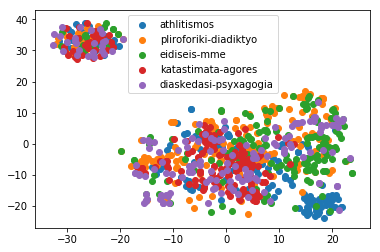

In [9]:
plot_embeddings(embeddings_line, train_hosts, y_train)

# Manifold Learning

### Laplacian EigenMaps
<br>
http://people.cs.pitt.edu/~milos/courses/cs3750-Fall2011/lectures/class16.pdf

In [73]:
all_nodes = train_hosts + test_hosts
G_undirect = G.to_undirected().copy()
lap_eigen = nx.laplacian_matrix(G_undirect, nodelist=all_nodes) # normalized_laplacian_matrix(G_undirect, nodelist=all_nodes)

In [74]:
lap_eigen = lap_eigen.toarray()

In [75]:
x_train_eigen = lap_eigen[:800]
x_test_eigen = lap_eigen[800:]

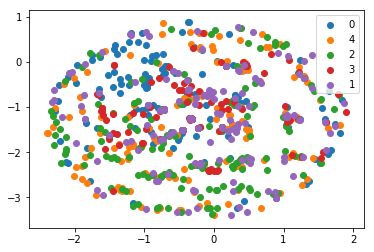

In [76]:
model = TSNE(n_components=2)
node_pos = model.fit_transform(x_train_eigen)

color_idx = {}
for i in range(len(train_hosts)):
    color_idx.setdefault(y_train[i], [])
    color_idx[y_train[i]].append(i)

for c, idx in color_idx.items():
    plt.scatter(node_pos[idx, 0], node_pos[idx, 1], label=c)
plt.legend()
plt.show()

In [141]:
import scipy as sp
G_X = nx.to_scipy_sparse_matrix(G)
G_X=G_X.tocsr()

In [ ]:
import sklearn as sk
res = sk.manifold.spectral_embedding(G_X, n_components=100, eigen_solver=None,
                                  random_state=None, eigen_tol=0.0, norm_laplacian=True,
                                  drop_first=True)

C:\Users\User\Anaconda3\envs\GPU\lib\site-packages\sklearn\utils\validation.py:892: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


### UMAP

In [ ]:
!pip install umap-learn
import umap
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(G)

## Embedding Selection

**Summary**

From the above methods strc2vec and LINE gave the worst results because we did not have the resources to train them properly. (we used the composed ego graph of radius 1 for s2v and we trained for only 3 epocks LINE).
<BR>

Random walks(DeepWalk) gave us best results when we tuned an SVM models.
<br>
DW final params:
* walk_length = 60
* number_walks = 200
* window_size = 6
* embeddings_size = 100

**DeepWalk Embeddings**

In [54]:
serialized_w2v_100_path = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/test_emb.pickle'
with open(serialized_w2v_100_path, 'rb') as file:
        X_train_G = pickle.load(file)
        
serialized_w2v_100_path = 'C:/Users/User/Desktop/DS_challenge/data/serialized_objects/graph_emb/train_emb.pickle'
with open(serialized_w2v_100_path, 'rb') as file:
        X_test_G = pickle.load(file)

In [23]:
# X_train_embedd = np.zeros((800, embed_size))
# for i in range(len(train_hosts)):
#     X_train_embedd[i, :]= model_rw.w2v_model[train_hosts[i]]

# X_test_embedd = np.zeros((200, embed_size))
# for i in range(len(test_hosts)):
#     X_test_embedd[i, :]= model_rw.w2v_model[test_hosts[i]]

NameError: name 'model_rw' is not defined

**LINE Embeddings**

In [83]:
# Libraries Embeddings
embed_size = 100
X_train_embedd_LINE = np.zeros((800, embed_size))
for i in range(len(train_hosts)):
    X_train_embedd_LINE[i, :]= embeddings_line[train_hosts[i]]

X_test_embedd_LINE = np.zeros((200, embed_size))
for i in range(len(test_hosts)):
    X_test_embedd_LINE[i, :]= embeddings_line[test_hosts[i]]

# Additional Graph information

In [18]:
from utils.community_louvain import best_partition

In [19]:
def get_graph_edges(train_hosts, test_hosts):
    # Create a directed graph
    G = nx.read_edgelist(GRAPH_FILE, delimiter=' ', \
                         create_using=nx.DiGraph())

    print(G.number_of_nodes())
    print(G.number_of_edges())

    # Create the training matrix. Each row corresponds to a web host.
    # Use the following 3 features for each web host:
    # (1) out-degree of node
    # (2) in-degree of node
    # (3) average degree of neighborhood of node
    X_train_graph = np.zeros((len(train_hosts), 3))
    avg_neig_deg = nx.average_neighbor_degree(G, 
                                              nodes=train_hosts)
    for i in range(len(train_hosts)):
        X_train_graph[i,0] = G.in_degree(train_hosts[i])
        X_train_graph[i,1] = G.out_degree(train_hosts[i])
        X_train_graph[i,2] = avg_neig_deg[train_hosts[i]]

    # Create the test matrix. Use the same 3 features as above
    X_test_graph = np.zeros((len(test_hosts), 3))
    avg_neig_deg = nx.average_neighbor_degree(G, nodes=test_hosts)
    for i in range(len(test_hosts)):
        X_test_graph[i,0] = G.in_degree(test_hosts[i])
        X_test_graph[i,1] = G.out_degree(test_hosts[i])
        X_test_graph[i,2] = avg_neig_deg[test_hosts[i]]

    print("Train matrix dimensionality: ", X_train_graph.shape)
    print("Test matrix dimensionality: ", X_test_graph.shape)
    
    return X_train_graph, X_test_graph, G

def get_communities(G):
    partition = best_partition(G.to_undirected())
    communities = set(list(partition.values()))    
    return communities, partition

def add_communities(communities, partition, data, hosts, G):
    X = np.zeros((len(hosts), 3 + len(communities)))
    for i in range(len(hosts)):
        X[i,0] = data[i,0]
        X[i,1] = data[i,1]
        X[i,2] = data[i,2]
        X[i,3+partition[hosts[i]]] = 1       
    return X

In [15]:
X_train_graph, X_test_graph, G = get_graph_edges(train_hosts, test_hosts)

65208
1642073
Train matrix dimensionality:  (800, 3)
Test matrix dimensionality:  (200, 3)


In [20]:
communities, partition = get_communities(G)

print("Number of communities: ", len(communities))

X_train_graph_comm = add_communities(communities,
                                 partition,
                                 X_train_graph,
                                 train_hosts,
                                 G)

X_test_graph_comm = add_communities(communities,
                                 partition,
                                 X_test_graph,
                                 test_hosts,
                                 G)

Number of communities:  10


# Combine Results

In [36]:
def combine(data, embeddings, hosts):
    rows = len(hosts)
    cols = embeddings.shape[1]
    X_final = np.zeros((rows, data.shape[1]+cols+1))

    num_cols = data.shape[1]
    for i, host in enumerate(hosts):
        X_final[i,:num_cols] = data[i,:num_cols]
        X_final[i,num_cols+1:] = embeddings[i]

    return X_final

In [37]:
X_train_final = combine(X_train_graph_comm,
                        X_train_embedd,
                        train_hosts)

X_test_final = combine(X_test_graph_comm,
                       X_test_embedd,
                       test_hosts)

In [38]:
print('Final train set shape: {}'.format(X_train_final.shape))
print('Final test set shape: {}'.format(X_test_final.shape))

Final train set shape: (800, 114)
Final test set shape: (200, 114)


# Train Models for  Graph/Node Embeddings<a id='models'></a>

Notes: 
* From various runs for the combined results we observed that we could not get the optimum result. Thus we kept only the graph embeddings which seemed to give us the best log loss from all the inputs.
* We tested three models to train the model for the graphs (logistic regression, xgboost, svm). From the three the best result was with SVM

## Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)

## SVM

Train SVM for various C, gamma:

In [113]:
seeds = [random.randint(1, 20000) for _ in range(100)]

res_train = []
res_val = []
x_indicies = list(range(0, 800))

for idx in range(len(seeds)):     
    X_tra, X_val, y_tra, y_val= train_test_split(x_indicies, y_train_class, train_size=0.87, random_state=seeds[idx], stratify=y_train_class)
    
    #Graph Samples
    X_tra_G = np.take(X_train_G, X_tra, axis=0)
    X_val_G = np.take(X_train_G, X_val, axis=0)

    y_tra_G = np.take(y_train_class ,X_tra, axis=0)
    y_val_G = np.take(y_train_class ,X_val, axis=0)
    
    y_tra_G_l = np.take(y_train_dum, X_tra, axis=0)
    y_val_G_l = np.take(y_train_dum, X_val, axis=0)
    
    svc = SVC(probability=True, C=1.45, kernel='rbf', gamma=0.035, random_state=5) #C=1.3, gamma=0.4
    svc.fit(X_tra_G, y_tra)

    y_pred_train = svc.predict_proba(X_tra_G)
    y_pred_val = svc.predict_proba(X_val_G)
    
    res_train.append(log_loss(y_tra_G_l, y_pred_train))
    res_val.append(log_loss(y_val_G_l, y_pred_val))    
    
    classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

    results = [classes[i] for i in np.argmax(y_pred_val,axis=1)]
    true_y = [classes[i] for i in np.argmax(y_val_G_l,axis=1)]
    # cm = confusion_matrix(true_y,results)
    # plt.figure(figsize = (10,7))
    # sn.heatmap(cm, annot=False, cmap="Blues")

print(classification_report(list(true_y), list(results)))#, target_names=svc.classes_))
    
print('Mean ll')
print(mean(res_train))
print(mean(res_val))

                       precision    recall  f1-score   support

          athlitismos       0.83      0.95      0.88        20
diaskedasi-psyxagogia       0.58      0.52      0.55        21
         eidiseis-mme       0.76      0.76      0.76        21
   katastimata-agores       0.67      0.86      0.75        21
pliroforiki-diadiktyo       0.64      0.43      0.51        21

            micro avg       0.70      0.70      0.70       104
            macro avg       0.70      0.70      0.69       104
         weighted avg       0.69      0.70      0.69       104

Mean ll
0.4732545623141473
0.872657646347156


In [102]:
res_val = np.array(res_val)
np.std(res_val)

0.06924480323381225

Text(0,0.5,'Validation Multiclass Log Loss')

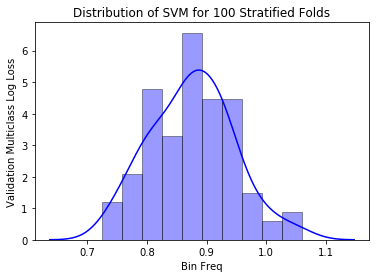

In [103]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn histogram
sns.distplot(res_val, hist=True, kde=True, 
             bins=10, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of SVM for 100 Stratified Folds')
plt.xlabel('Bin Freq')
plt.ylabel('Validation Multiclass Log Loss')

## XGBoost Classifier - Laplacian EigenMap 

In [79]:
# Finds class 4
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import log_loss

X_tra, X_val, y_tra, y_val = train_test_split(x_train_eigen, y_train_class,
                                              train_size=0.90, random_state=2,
                                              stratify=y_train_class)


mcw = 20
md = 3

g = 7
xgb = XGBClassifier(objective ='multi:softprob', learning_rate = 0.01,
                     max_depth = 10, alpha = 10, n_estimators = 300,
                     eval_metris='mlogloss',
                     reg_lambda=0.8
                     )

xgb.fit(X_tra, y_tra)
y_pred_train = xgb.predict_proba(X_tra)
y_pred_val = xgb.predict_proba(X_val)        

print(xgb.score(X_tra, y_tra))
print(xgb.score(X_val, y_val))

print('Loss')
print(log_loss(y_tra, y_pred_train))
print(log_loss(y_val, y_pred_val))


0.8430555555555556
0.525
Loss
0.6411582451210254
1.1586405142210423


In [131]:
y_test_lap_eigen = xgb.predict_proba(x_test_eigen)

# Final Model Train

In [112]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline



classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

results = [classes[i] for i in np.argmax(y_pred_val,axis=1)]
true_y = [classes[i] for i in np.argmax(y_val_G_l,axis=1)]
# cm = confusion_matrix(true_y,results)
# plt.figure(figsize = (10,7))
# sn.heatmap(cm, annot=False, cmap="Blues")

print(classification_report(list(true_y), list(results)))#, target_names=svc.classes_))

                       precision    recall  f1-score   support

          athlitismos       0.94      0.85      0.89        20
diaskedasi-psyxagogia       0.62      0.71      0.67        21
         eidiseis-mme       0.71      0.57      0.63        21
   katastimata-agores       0.76      0.76      0.76        21
pliroforiki-diadiktyo       0.46      0.52      0.49        21

            micro avg       0.68      0.68      0.68       104
            macro avg       0.70      0.68      0.69       104
         weighted avg       0.70      0.68      0.69       104



From the above confusion matrix it seems that the graph model seems to missvlassify 'pliroforiki-diadiktio' to 'eidiseis-mme'. So we thought to add an additional 'helper' model to identify only those two categories and in case the main model classifies something to 'eidiseis-mme' to cross-check it vs the helper model.

### Helper Model

In [91]:
classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

sub_classes = ['eidiseis-mme', 'pliroforiki-diadiktyo']

idx = [i for i in range(len(train_hosts)) if y_train[i] in sub_classes]

X_train_sub = X_train_final[idx]
y_train_sub = [y_train[i] for i in idx ]
#y_train_sub = np.reshape(y_train_sub, (X_train_sub.shape[0], 2))

print('Helper Dataset shape X: {}'.format(X_train_sub.shape))
print('Helper Dataset shape y: {}'.format(len(y_train_sub)))

Helper Dataset shape X: (322, 114)
Helper Dataset shape y: 322


### Tuning

In [116]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train_sub, y_train_sub,
                                              train_size=0.7, random_state=42,
                                              stratify=y_train_sub)

mcw = 10
md = 8
g = 7

xgb = XGBClassifier(random_state=0, min_child_weight = mcw, gamma = g, max_depth = md)
xgb.fit(X_tra, y_tra)
y_pred_train = xgb.predict_proba(X_tra)
y_pred_val = xgb.predict_proba(X_val)

print('min_child_weight = {} , gamma = {},  max_depth={}'.format(mcw,g,md))
print(xgb.score(X_tra, y_tra))
print(xgb.score(X_val, y_val))
print('Loss')
print(log_loss(y_tra, y_pred_train))
print(log_loss(y_val, y_pred_val))

min_child_weight = 10 , gamma = 7,  max_depth=8
0.8666666666666667
0.6907216494845361
Loss
0.5051622792747286
0.6151395421667197


In [191]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train_sub, y_train_sub,
                                              train_size=0.7, random_state=42,
                                              stratify=y_train_sub)

C = 1.1
gamma = 0.001
while C<=2.0:
    while gamma <= 0.005:
        svc = SVC(probability=True, C=C, kernel='rbf', gamma=gamma, random_state=7)
        # svc = SVC(probability=True, C=1.192, kernel='rbf', gamma='auto', random_state=0)
        svc.fit(X_tra, y_tra)
        y_pred_train = svc.predict_proba(X_tra)
        y_pred_val = svc.predict_proba(X_val)

        if ((abs(svc.score(X_tra, y_tra) - svc.score(X_val, y_val))) <= 0.06 ) \
            & (log_loss(y_tra, y_pred_train)<0.97):
            print('C = {} , gamma = {} '.format(C,gamma))
            print(svc.score(X_tra, y_tra))
            print(svc.score(X_val, y_val))
            print('Loss')
            print(log_loss(y_tra, y_pred_train))
            print(log_loss(y_val, y_pred_val))
        gamma+=0.00005
    gamma = 0.001
    C+=0.01

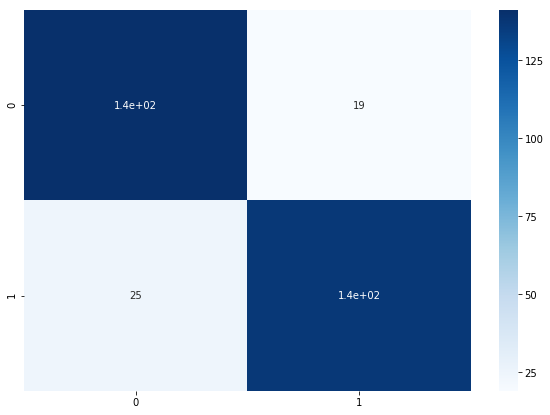

In [118]:
xgb = XGBClassifier(random_state=0, min_child_weight = mcw, gamma = g, max_depth = md)
xgb.fit(X_train_sub, y_train_sub)
y_pred_tmp = xgb.predict_proba(X_train_sub)


classes = { 1:'pliroforiki-diadiktyo', 0:'eidiseis-mme', }
results = [classes[i] for i in np.argmax(y_pred_tmp,axis=1)]
cm = confusion_matrix(y_train_sub,results)
plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, cmap="Blues")

# Output

In [176]:
y_pred_test = svc.predict_proba(X_test_embedd)
y_sub_test = xgb.predict_proba(X_test_final)

test_classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

sub_classes = ['eidiseis-mme', 'pliroforiki-diadiktyo']

idx = [i for i in range(len(test_hosts)) if test_classes[np.argmax(y_pred_test[i])] in sub_classes]

y_test_final = np.zeros(y_pred_test.shape)
for i in range(len(test_hosts)):
    y_test_final[i] = y_pred_test[i] if i not in idx else  [y_pred_test[i,0]
                                                           ,y_pred_test[i,1]
                                                           ,(y_pred_test[i,2] + y_sub_test[i,0])/2
                                                           ,y_pred_test[i,3]
                                                           ,(y_pred_test[i,4] + y_sub_test[i,1])/2
                                                           ]

In [134]:
test_classes = {0:'athlitismos', 1:'diaskedasi-psyxagogia', 2:'eidiseis-mme',
       3:'katastimata-agores', 4:'pliroforiki-diadiktyo'}

with open('graph_classification.csv', 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    lst = svc.classes_.tolist()
    lst.insert(0, "Host")
    writer.writerow(lst)
    for i,test_host in enumerate(test_hosts):
        lst = y_final_pred[i,:].tolist()
        lst.insert(0, test_host)
        writer.writerow(lst)

In [128]:
y_pred_DW_G = pd.read_csv('C:/Users/User/Desktop/DS_challenge/notebooks/sample_submission_22.csv').set_index('Host')
y_test_lap_eigen

In [140]:
c=0
y_final_pred = np.zeros((200,5))
for i in range(len(y_test_lap_eigen)):
    if np.argmax(y_test_lap_eigen[i])==4:
        y_final_pred[i] = y_test_lap_eigen[i]
        print(np.argmax(y_test_lap_eigen[i]), np.argmax(np.array(y_pred_DW_G.iloc[i])))
        print(y_test_lap_eigen[i], np.array(y_pred_DW_G.iloc[i]))
        c+=1
    else:
        y_final_pred[i] = np.array(y_pred_DW_G.iloc[i])
print(c)

4 2
[0.15514846 0.1843898  0.10579321 0.2705594  0.28410915] [0.09316158 0.11125539 0.58452606 0.03207214 0.17898484]
4 4
[0.04801336 0.05442408 0.14631015 0.04872549 0.70252687] [0.00993318 0.03540375 0.25317789 0.01573621 0.68574898]
4 2
[0.0455841  0.05278319 0.4090496  0.05141983 0.4411633 ] [0.00712    0.01650129 0.60647501 0.0033269  0.36657681]
4 4
[0.15551192 0.24227978 0.15849869 0.0697438  0.37396583] [0.02895868 0.25965818 0.06168527 0.02521816 0.62447972]
4 1
[0.13071474 0.24060416 0.14628994 0.07329793 0.40909326] [0.0948951  0.4841212  0.20748384 0.01620097 0.19729889]
4 1
[0.15183626 0.32070664 0.13679932 0.05739358 0.33326423] [0.10076539 0.37947144 0.0350896  0.34241902 0.14225455]
4 2
[0.03737748 0.09489667 0.09817465 0.03557241 0.7339788 ] [0.00915013 0.01916494 0.5869718  0.01687681 0.36783631]
4 4
[0.05083288 0.18057871 0.12013545 0.0392628  0.60919017] [0.08505236 0.25908648 0.19906411 0.00598993 0.45080713]
4 2
[0.05955148 0.16490625 0.27618736 0.05417078 0.44518